In [1]:
!pip install xgboost

# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error,mean_absolute_error
import math
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="Set2")
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

In [2]:
df=pd.read_csv("AMZN BP DATA.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
0,01-04-2014,16.904499,17.221500,16.900000,17.1495,72002000.0,3.0,NaN,3658.399902
1,02-04-2014,17.299500,17.415001,17.018999,17.0980,89510000.0,4.0,-0.0515,3665.989990
2,03-04-2014,17.091000,17.125000,16.423000,16.6810,127986000.0,5.0,-0.4170,3637.580078
3,04-04-2014,16.757500,16.771999,15.780500,16.1500,250692000.0,6.0,-0.5310,3539.379883
4,07-04-2014,16.049500,16.247000,15.656500,15.8880,141548000.0,2.0,-0.2620,3507.750000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2205 non-null   object 
 1   Open             2205 non-null   float64
 2   High             2205 non-null   float64
 3   Low              2205 non-null   float64
 4   Close            2205 non-null   float64
 5   Volume           2205 non-null   float64
 6   Day of the week  2205 non-null   float64
 7   Change           2204 non-null   float64
 8   NASDAQ           2205 non-null   float64
dtypes: float64(8), object(1)
memory usage: 159.5+ KB


## Convert the "time" column to the datetime type

In [5]:
df["Date"] = pd.to_datetime(df["Date"])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             2205 non-null   datetime64[ns]
 1   Open             2205 non-null   float64       
 2   High             2205 non-null   float64       
 3   Low              2205 non-null   float64       
 4   Close            2205 non-null   float64       
 5   Volume           2205 non-null   float64       
 6   Day of the week  2205 non-null   float64       
 7   Change           2204 non-null   float64       
 8   NASDAQ           2205 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 159.5 KB


In [7]:
df.set_index('Date',inplace=True)

In [8]:
df.head()

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
Date,,,,,,,,
2014-01-04,16.904499,17.221500,16.900000,17.1495,72002000.0,3.0,NaN,3658.399902
2014-02-04,17.299500,17.415001,17.018999,17.0980,89510000.0,4.0,-0.0515,3665.989990
2014-03-04,17.091000,17.125000,16.423000,16.6810,127986000.0,5.0,-0.4170,3637.580078
2014-04-04,16.757500,16.771999,15.780500,16.1500,250692000.0,6.0,-0.5310,3539.379883
2014-07-04,16.049500,16.247000,15.656500,15.8880,141548000.0,2.0,-0.2620,3507.750000


In [9]:
df = df.iloc[:-62, :]

In [10]:
df.tail()

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
Date,,,,,,,,
2022-12-23,83.250000,85.779999,82.930000,85.250000,57433700.0,6.0,1.459999,10985.45020
2022-12-27,84.970001,85.349998,83.000000,83.040001,57284000.0,3.0,-2.209999,10822.50977
2022-12-28,82.800003,83.480003,81.690002,81.820000,58228600.0,4.0,-1.220001,10679.33984
2022-12-29,82.870003,84.550003,82.550003,84.180000,54995900.0,5.0,2.360000,10951.04981
2022-12-30,83.120003,84.050003,82.470001,84.000000,62401200.0,6.0,-0.180000,10939.75977


# Missing entries


In [11]:
min(df.index)

Timestamp('2014-01-04 00:00:00')

In [12]:
max(df.index)

Timestamp('2022-12-30 00:00:00')

In [13]:
all_datetimes = pd.date_range(min(df.index), max(df.index), freq="D")
all_datetimes

DatetimeIndex(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13',
               ...
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', length=3283, freq='D')

In [14]:
all_datetimes.shape

(3283,)

# Supplying missing values


## Insert missing datetimes

In [15]:
all_datetimes_df = pd.DataFrame(index=all_datetimes)
all_datetimes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Empty DataFrame

In [16]:
df = pd.merge(all_datetimes_df, df, how="left", left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             2205 non-null   float64
 1   High             2205 non-null   float64
 2   Low              2205 non-null   float64
 3   Close            2205 non-null   float64
 4   Volume           2205 non-null   float64
 5   Day of the week  2205 non-null   float64
 6   Change           2204 non-null   float64
 7   NASDAQ           2205 non-null   float64
dtypes: float64(8)
memory usage: 359.9 KB


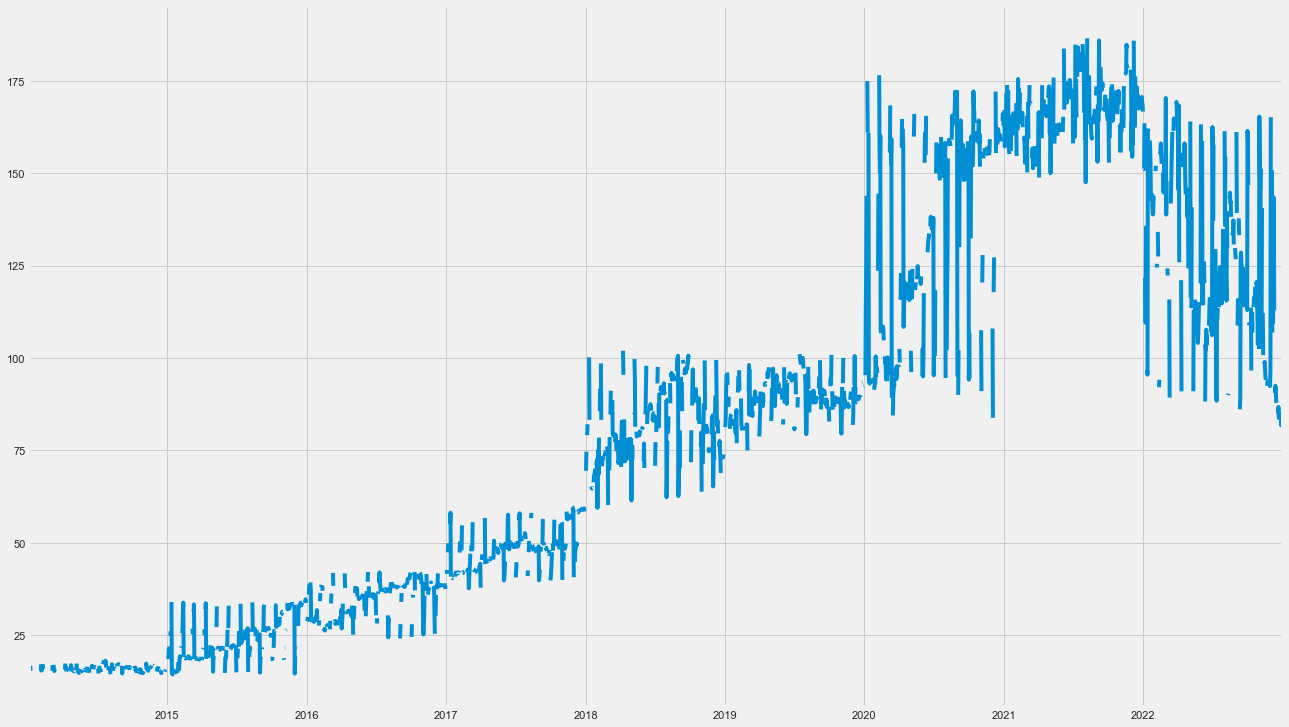

In [17]:
plot = df['Close'].plot(figsize=(20, 12))

# forward fill

In [18]:
df["ffilled"] = df["Close"].ffill()
df["NASDAQ"]=df["NASDAQ"].ffill()
df.head(12)

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ,ffilled
2014-01-04,16.904499,17.2215,16.900000,17.149500,72002000.0,3.0,NaN,3658.399902,17.149500
2014-01-05,15.206500,15.5240,15.200000,15.394500,86572000.0,5.0,0.188000,3594.360107,15.394500
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3594.360107,15.394500
2014-01-07,16.292999,16.6600,16.254999,16.619499,63472000.0,3.0,0.380499,3894.330078,16.619499
2014-01-08,15.684500,15.7915,15.229500,15.353000,148830000.0,6.0,-0.296500,3879.669922,15.353000
2014-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3879.669922,15.353000
2014-01-10,16.101999,16.1085,15.777500,15.873000,61782000.0,4.0,-0.249000,3984.739990,15.873000
2014-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3984.739990,15.873000
2014-01-12,16.906000,17.0320,16.296499,16.299999,98898000.0,2.0,-0.632000,4287.810059,16.299999
2014-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4287.810059,16.299999


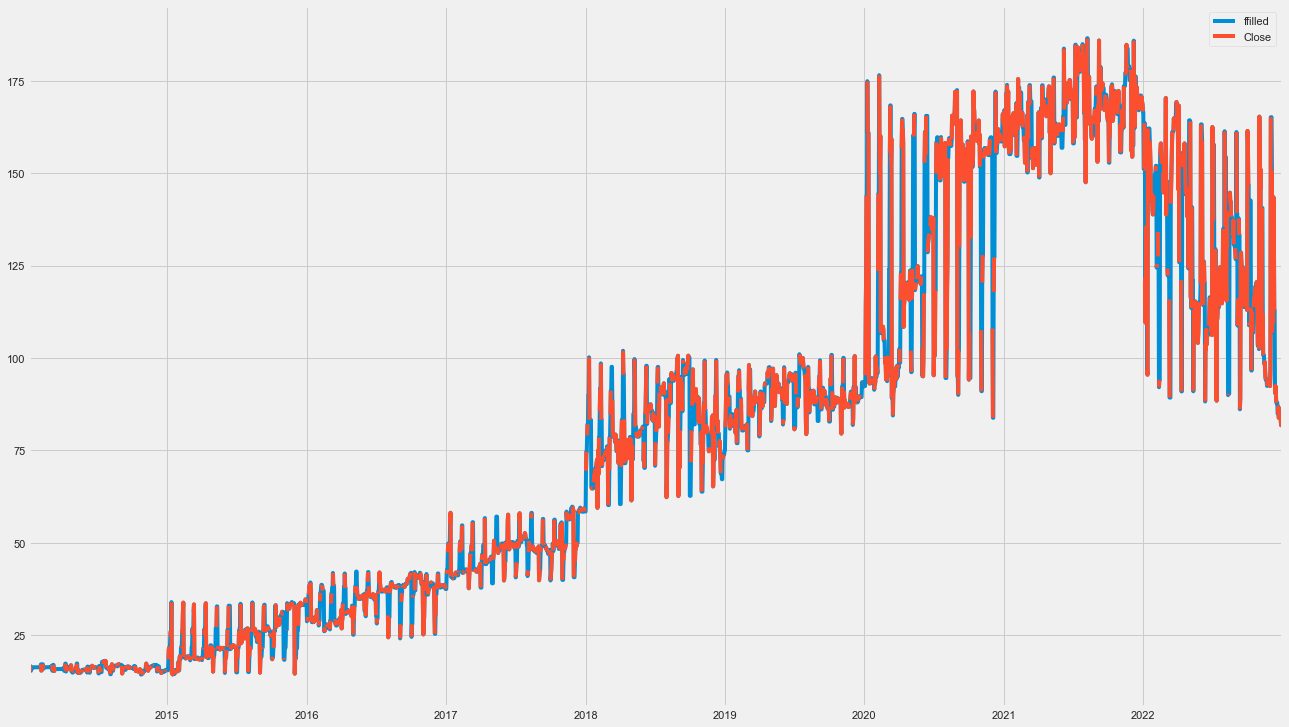

In [19]:
df = df[["ffilled", "Close","NASDAQ","Change"]]
plot = df[["ffilled", "Close"]].plot(figsize=(20, 12))

In [20]:
df.ffilled

2014-01-04    17.149500
2014-01-05    15.394500
2014-01-06    15.394500
2014-01-07    16.619499
2014-01-08    15.353000
                ...    
2022-12-26    85.250000
2022-12-27    83.040001
2022-12-28    81.820000
2022-12-29    84.180000
2022-12-30    84.000000
Freq: D, Name: ffilled, Length: 3283, dtype: float64

In [21]:
df.rename(columns={"ffilled": "close"}, inplace=True)
df

,close,Close,NASDAQ,Change
2014-01-04,17.149500,17.149500,3658.399902,NaN
2014-01-05,15.394500,15.394500,3594.360107,0.188000
2014-01-06,15.394500,NaN,3594.360107,NaN
2014-01-07,16.619499,16.619499,3894.330078,0.380499
2014-01-08,15.353000,15.353000,3879.669922,-0.296500
...,...,...,...,...
2022-12-26,85.250000,NaN,10985.450200,NaN
2022-12-27,83.040001,83.040001,10822.509770,-2.209999
2022-12-28,81.820000,81.820000,10679.339840,-1.220001
2022-12-29,84.180000,84.180000,10951.049810,2.360000


In [22]:
df.drop(["Close"],axis=1,inplace=True)

In [23]:
df

,close,NASDAQ,Change
2014-01-04,17.149500,3658.399902,NaN
2014-01-05,15.394500,3594.360107,0.188000
2014-01-06,15.394500,3594.360107,NaN
2014-01-07,16.619499,3894.330078,0.380499
2014-01-08,15.353000,3879.669922,-0.296500
...,...,...,...
2022-12-26,85.250000,10985.450200,NaN
2022-12-27,83.040001,10822.509770,-2.209999
2022-12-28,81.820000,10679.339840,-1.220001
2022-12-29,84.180000,10951.049810,2.360000


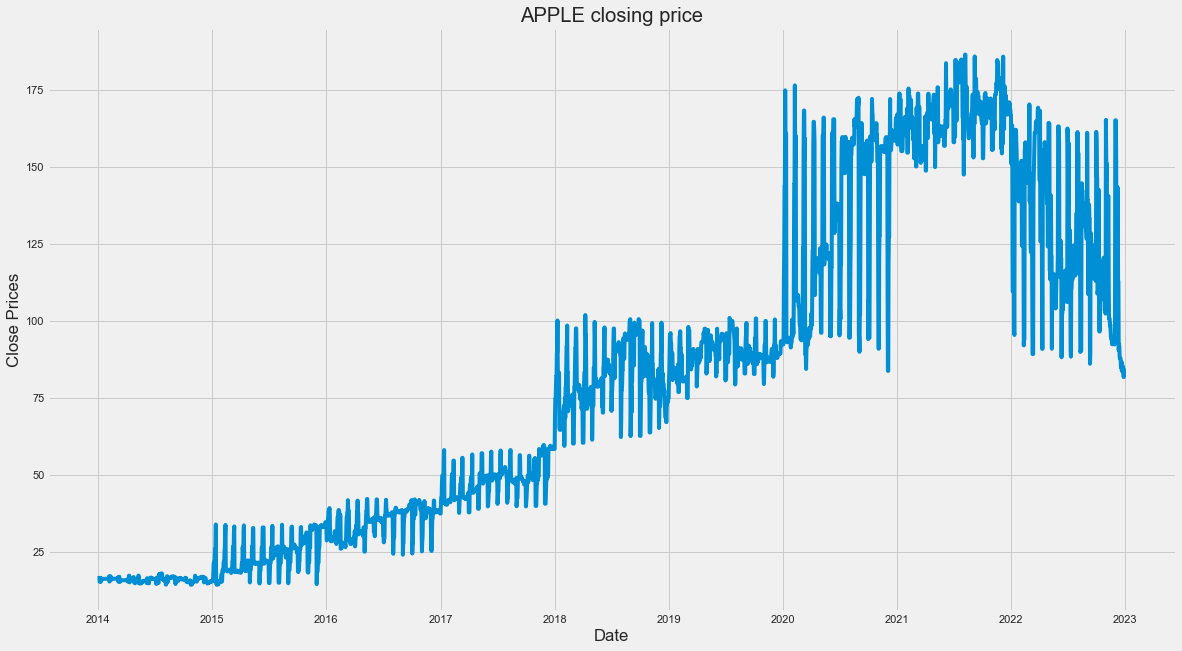

In [24]:
#plot close price
plt.figure(figsize=(18,10))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['close'])
plt.title('APPLE closing price')
plt.show()

# checking stationarity of the data


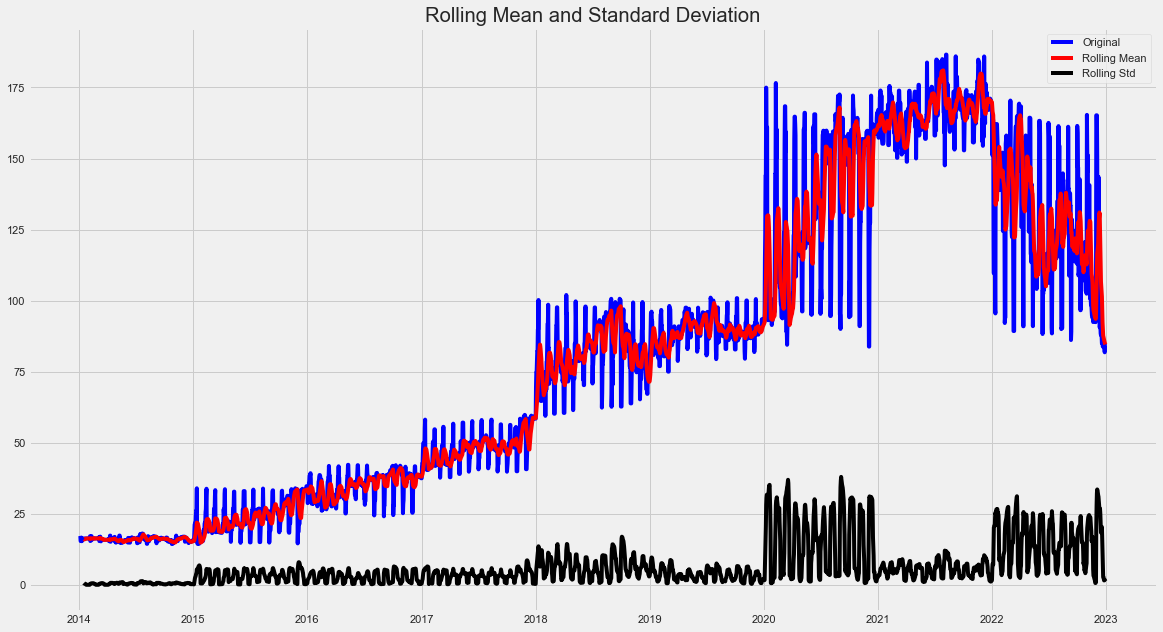

Results of dickey fuller test
Test Statistics                  -1.297927
p-value                           0.630120
No. of lags used                 29.000000
Number of observations used    3253.000000
critical value (1%)              -3.432362
critical value (5%)              -2.862429
critical value (10%)             -2.567243
dtype: float64


In [25]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    plt.figure(figsize=(18, 10))

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df.close)

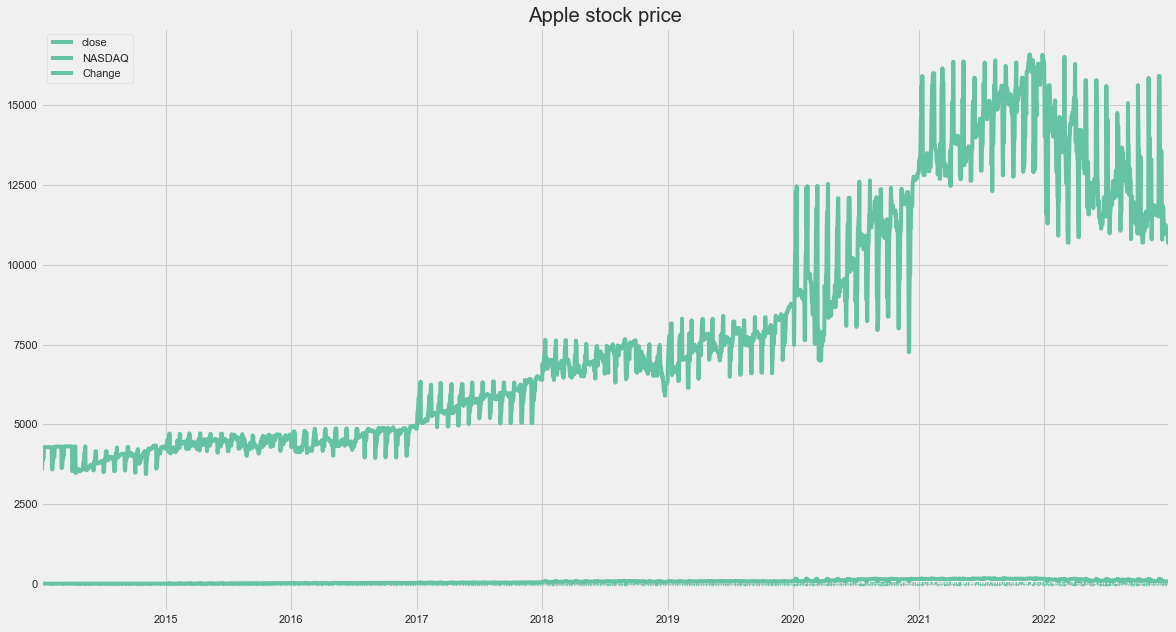

In [26]:
df.plot(style='-',
        figsize=(18, 10),
        color=color_pal[0],
        title='Apple stock price')
plt.show()

## Train / Test Split¶


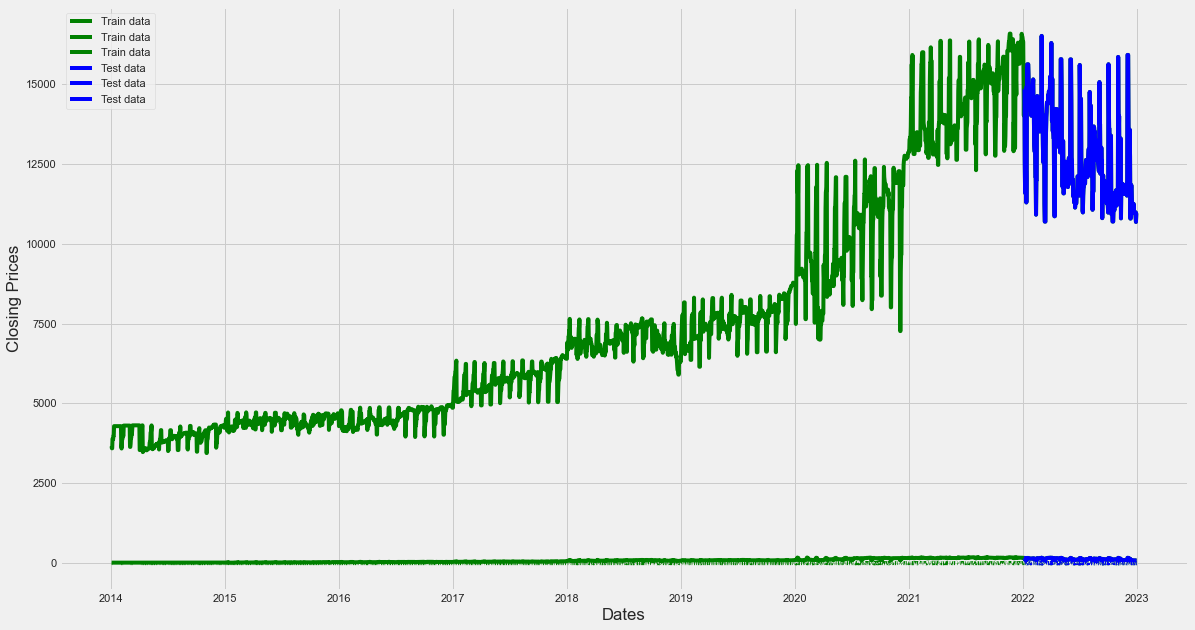

In [27]:
train_data = df.loc[df.index < '01-04-2022']
test_data = df.loc[df.index >= '01-04-2022']
plt.figure(figsize=(18,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [28]:
train_data.shape

(2922, 3)

In [29]:
test_data.tail()

,close,NASDAQ,Change
2022-12-26,85.250000,10985.45020,NaN
2022-12-27,83.040001,10822.50977,-2.209999
2022-12-28,81.820000,10679.33984,-1.220001
2022-12-29,84.180000,10951.04981,2.360000
2022-12-30,84.000000,10939.75977,-0.180000


In [30]:
test_data.shape

(361, 3)

In [31]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship¶


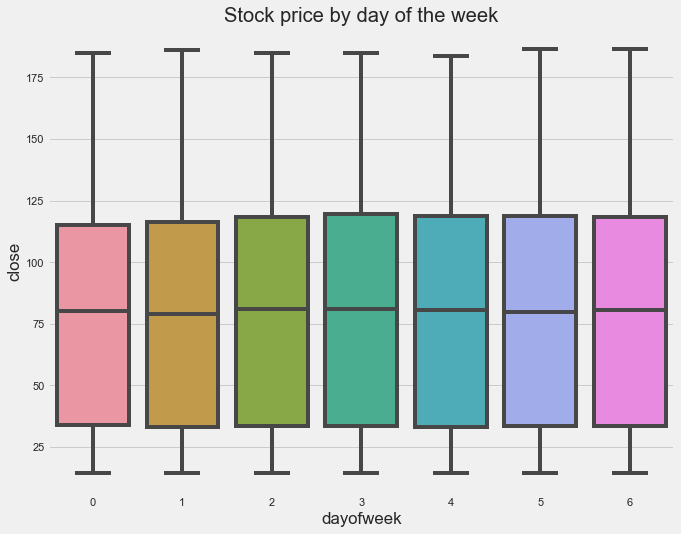

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='close')
ax.set_title('Stock price by day of the week')
plt.show()

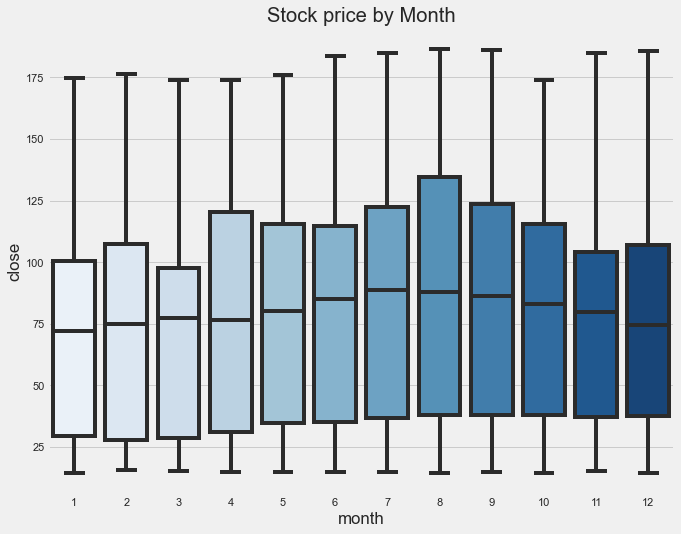

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='close', palette='Blues')
ax.set_title('Stock price by Month')
plt.show()

# Create our Model¶


In [34]:
train = create_features(train_data)
test = create_features(test_data)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year','NASDAQ','Change']
TARGET = 'close'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [35]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:89.48168	validation_1-rmse:126.20015
[100]	validation_0-rmse:33.25073	validation_1-rmse:31.19210
[200]	validation_0-rmse:12.85654	validation_1-rmse:24.57302


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance¶


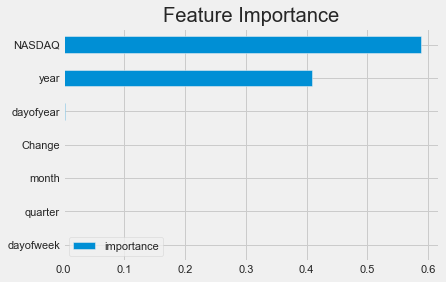

In [36]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test


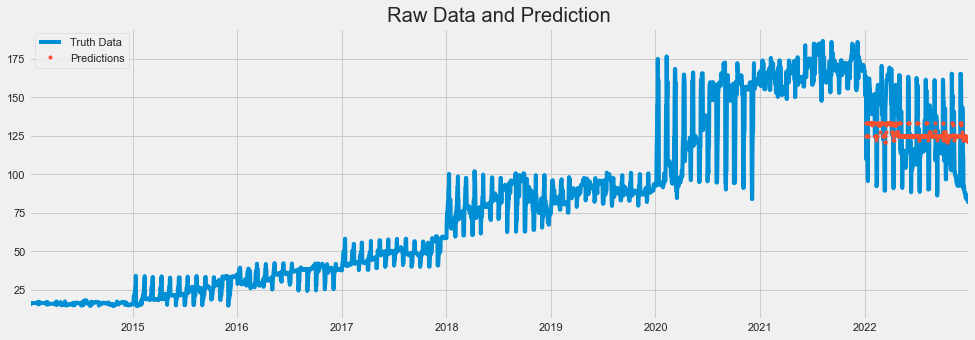

In [39]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['close']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

# Create a figure and axis
#fig, ax = plt.subplots(figsize=(12, 6))

# Plot the 'close' data as a line plot with a blue color
#ax.plot(df.index, df['close'], label='Truth Data', color='blue', linewidth=2)

# Plot the 'prediction' data as scattered points with a red color
#ax.scatter(df.index, df['prediction'], label='Predictions', color='red', marker='o', s=20)

# Add a legend
#ax.legend()

# Set the title and labels for the axes
#ax.set_title('Stock Price Prediction')
#ax.set_xlabel('Dates')
#ax.set_ylabel('Closing Prices')

# Rotate x-axis labels for better readability (optional)
#plt.xticks(rotation=45)

# Add a grid
#ax.grid(True)

# Show the plot
#plt.tight_layout()
#plt.show()

In [ ]:
df['prediction'].tail(365)

In [ ]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['close'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [ ]:
score = np.sqrt(mean_squared_error(test['close'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

# Calculate error

In [38]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

KeyError: 'prediction'

In [43]:
# report performance
mse = mean_squared_error(test['prediction'], test[TARGET])
print('MSE: '+str(mse))
mae = mean_absolute_error(test['prediction'], test[TARGET])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test['prediction'], test[TARGET]))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test[TARGET] - test['prediction'])/np.abs(test['prediction']))
print('MAPE: '+str(mape))

MSE: 426.92798087430094
MAE: 17.69929486546837
RMSE: 20.66223562140121
MAPE: 0.13904404601823211
